# Libraries

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    mean_absolute_error,
    explained_variance_score,
    median_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [10]:
# pd.set_option('display.max_columns', None)
# pd.read_csv(r'C:\Users\fgks1\Desktop\folder\jobs\cerved\AVM_project\Greek_housing_market_2022.csv')

# Geospatial feature engineering

In [28]:
import os

# Path to the folder
folder_path = "/kaggle/input/greece-metro-points-osm"

# List all .shp files
shp_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.shp')]

print("Shapefiles in folder:")
for shp in shp_files:
    print(os.path.join(folder_path, shp))


Shapefiles in folder:
/kaggle/input/greece-metro-points-osm/gis_osm_transport_free_1.shp
/kaggle/input/greece-metro-points-osm/gis_osm_traffic_a_free_1.shp
/kaggle/input/greece-metro-points-osm/gis_osm_water_a_free_1.shp
/kaggle/input/greece-metro-points-osm/gis_osm_railways_free_1.shp
/kaggle/input/greece-metro-points-osm/gis_osm_waterways_free_1.shp
/kaggle/input/greece-metro-points-osm/gis_osm_transport_a_free_1.shp
/kaggle/input/greece-metro-points-osm/gis_osm_traffic_free_1.shp
/kaggle/input/greece-metro-points-osm/gis_osm_pofw_a_free_1.shp
/kaggle/input/greece-metro-points-osm/gis_osm_landuse_a_free_1.shp
/kaggle/input/greece-metro-points-osm/gis_osm_places_a_free_1.shp
/kaggle/input/greece-metro-points-osm/gis_osm_pofw_free_1.shp
/kaggle/input/greece-metro-points-osm/gis_osm_pois_a_free_1.shp
/kaggle/input/greece-metro-points-osm/gis_osm_pois_free_1.shp
/kaggle/input/greece-metro-points-osm/gis_osm_natural_a_free_1.shp
/kaggle/input/greece-metro-points-osm/gis_osm_places_free_1.

In [ ]:
# ------------------------
# 1. Setup geocoder
# ------------------------
geolocator = Nominatim(user_agent="avm_project")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)  # 1 request/sec

# ------------------------
# 2. Geocode unique locations in Athens
# ------------------------
unique_locations = df['location_name'].dropna().unique()
print("Unique locations:", len(unique_locations))

geo_dict = {}
for loc in unique_locations:
    try:
        query = f"{loc}, Athens, Greece"  # force Athens context
        result = geocode(query)
        if result:
            geo_dict[loc] = (result.latitude, result.longitude)
        else:
            geo_dict[loc] = (None, None)
    except Exception:
        geo_dict[loc] = (None, None)

# ------------------------
# 3. Map coordinates back to full df
# ------------------------
df['lat'] = df['location_name'].map(lambda x: geo_dict.get(x, (None, None))[0])
df['long'] = df['location_name'].map(lambda x: geo_dict.get(x, (None, None))[1])

# Drop rows without geocoding results (optional)
df = df.dropna(subset=['lat', 'long']).reset_index(drop=True)

# ------------------------
# 4. Load metro points shapefile
# ------------------------
metros = gpd.read_file('/kaggle/input/greece-metro-points-osm/gis_osm_pois_free_1.shp')

# ------------------------
# 5. Create GeoDataFrames
# ------------------------
gdf = gpd.GeoDataFrame(df, 
                       geometry=[Point(xy) for xy in zip(df['long'], df['lat'])],
                       crs="EPSG:4326")

# Reproject both to metric CRS (meters)
gdf_2100 = gdf.to_crs("EPSG:2100")
metros_2100 = metros.to_crs("EPSG:2100")

# ------------------------
# 6. Compute nearest metro distance using STRtree (vectorized)
# ------------------------
metros_geoms = metros_2100.geometry.values
metros_tree = STRtree(metros_geoms)

# Get nearest metro geometry for each point
nearest_geoms = [metros_geoms[metros_tree.nearest(pt)] for pt in gdf_2100.geometry.values]

# Compute distance in meters
distances = [pt.distance(nearest) for pt, nearest in zip(gdf_2100.geometry.values, nearest_geoms)]

# Assign distances back to main GeoDataFrame
gdf['dist_to_metro'] = pd.Series(distances).round(2)

# ------------------------
# 7. Quick sanity check
# ------------------------
print("Max distance to metro (meters):", gdf['dist_to_metro'].max())
print(gdf[['location_name', 'lat', 'long', 'dist_to_metro']].head())


# Visualization

In [13]:
# cleaned and containes geospatial data. distance from metro
gdf = pd.read_csv('/kaggle/input/greek-house-market-of-2022-cleaned-with-geo/ghm_2022_cleaned_geo.csv')

<Figure size 1000x600 with 0 Axes>

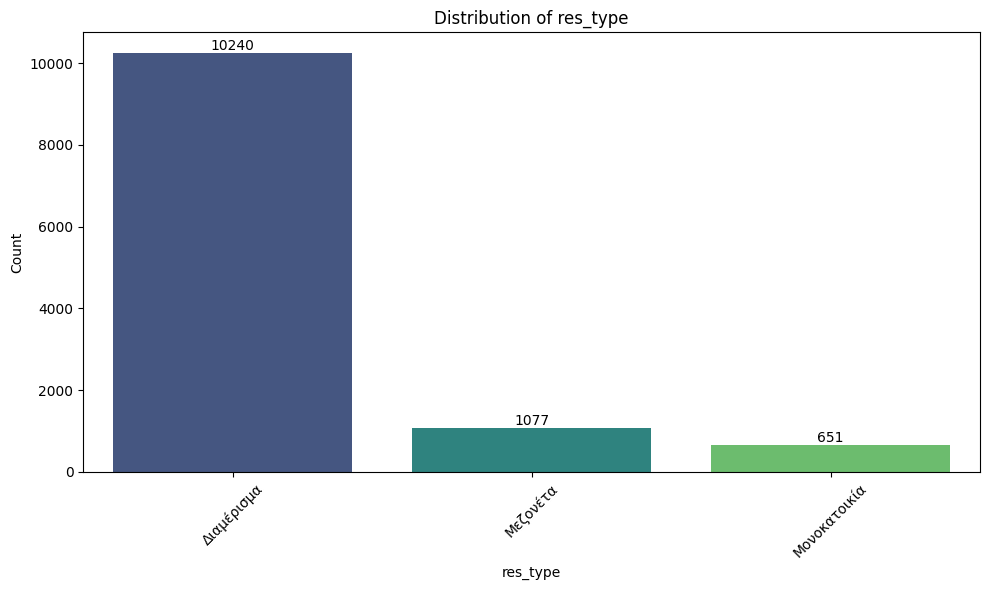

In [12]:
res_type_counts = gdf['res_type'].value_counts().reset_index()
res_type_counts.columns = ['res_type', 'count']

plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=res_type_counts,
    x='res_type',
    y='count',
    palette='viridis'
)


plt.title('Distribution of res_type')
plt.xlabel('res_type')
plt.ylabel('Count')
plt.xticks(rotation=45)

for i, row in res_type_counts.iterrows():
    ax.text(i, row['count'] + 0.5, str(row['count']), ha='center', va='bottom')

plt.tight_layout()
plt.show()

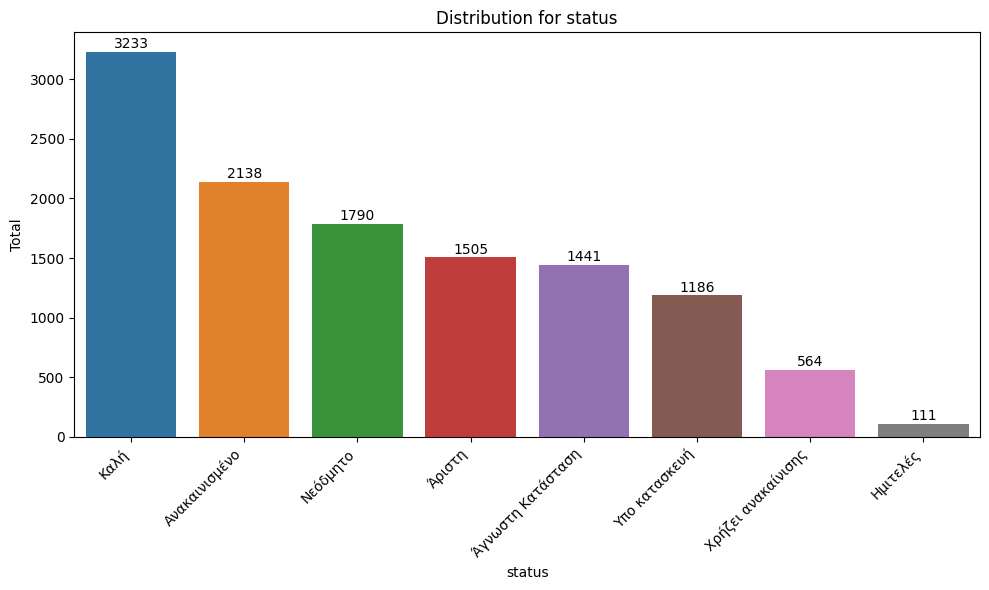

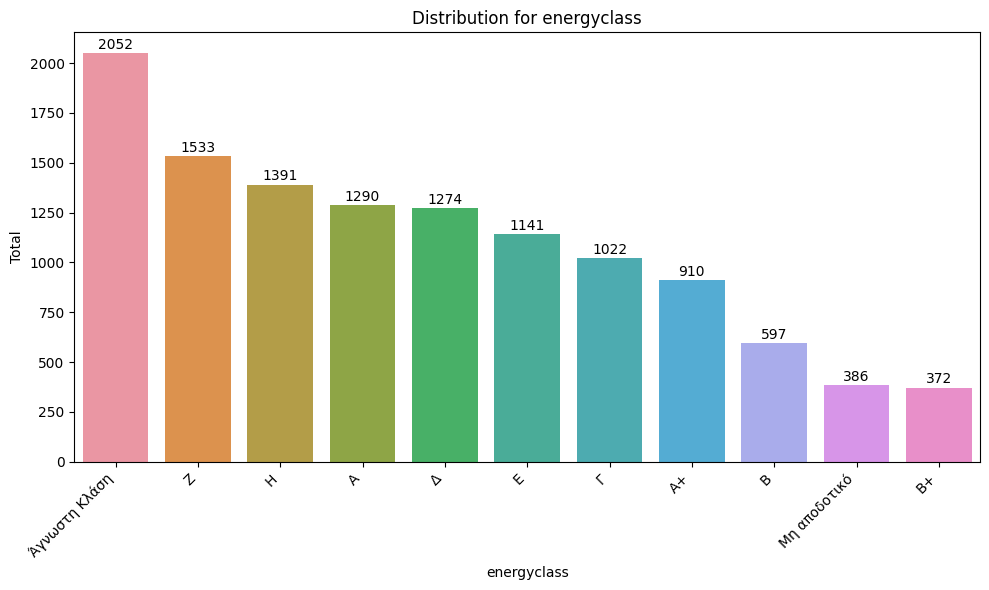

In [16]:
def plot_value_counts(df, column):
    counts = df[column].value_counts(dropna=False)
    plt.figure(figsize=(10,6))
    ax = sns.barplot(x=counts.index.astype(str), y=counts.values)
    plt.title(f'Distribution for {column}')
    plt.ylabel('Total')
    plt.xlabel(column)
    plt.xticks(rotation=45, ha='right')
    
    for i, v in enumerate(counts.values):
        ax.text(i, v + max(counts.values)*0.01, str(v), ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

plot_value_counts(gdf, 'status')

plot_value_counts(gdf, 'energyclass')

### In order to be able to work with energyclass and status features, we must convert them from categorical to numerical. One way for doing so, is with one-hot encoding.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


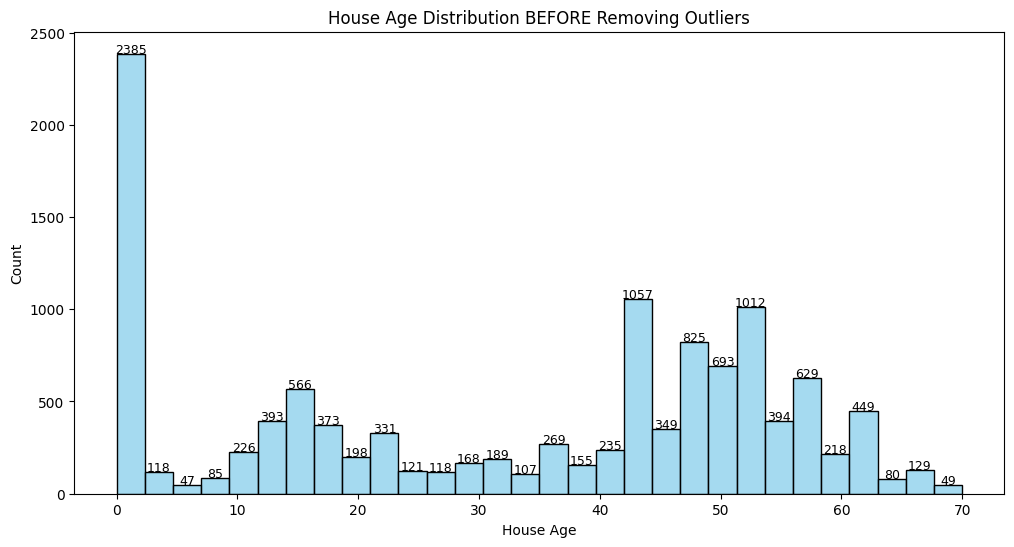

In [18]:
def plot_house_age_with_counts(data, title):
    plt.figure(figsize=(12, 6))
    ax = sns.histplot(data['house_age'], bins=30, kde=False, color='skyblue')
    plt.title(title)
    plt.xlabel('House Age')
    plt.ylabel('Count')
    
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width()/2, height + 3, int(height), ha='center', fontsize=9)
    
    plt.show()

plot_house_age_with_counts(gdf, "House Age Distribution BEFORE Removing Outliers")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


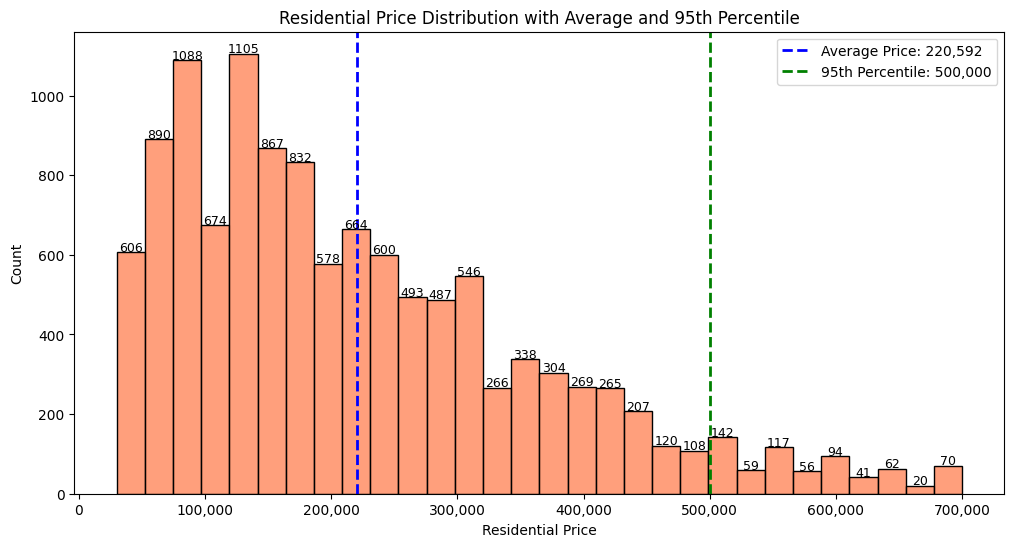

In [20]:
def plot_price_distribution_with_stats(data, title):
    plt.figure(figsize=(12, 6))
    ax = sns.histplot(data['res_price'], bins=30, kde=False, color='coral')
    plt.title(title)
    plt.xlabel('Residential Price')
    plt.ylabel('Count')

    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

    avg_price = data['res_price'].mean()
    p95_price = data['res_price'].quantile(0.95)

    ax.axvline(avg_price, color='blue', linestyle='--', linewidth=2, label=f'Average Price: {avg_price:,.0f}')
    ax.axvline(p95_price, color='green', linestyle='--', linewidth=2, label=f'95th Percentile: {p95_price:,.0f}')

    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.text(p.get_x() + p.get_width()/2, height + 3, int(height), ha='center', fontsize=9)

    plt.legend()
    plt.show()

# Call the function to plot
plot_price_distribution_with_stats(gdf, "Residential Price Distribution with Average and 95th Percentile")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


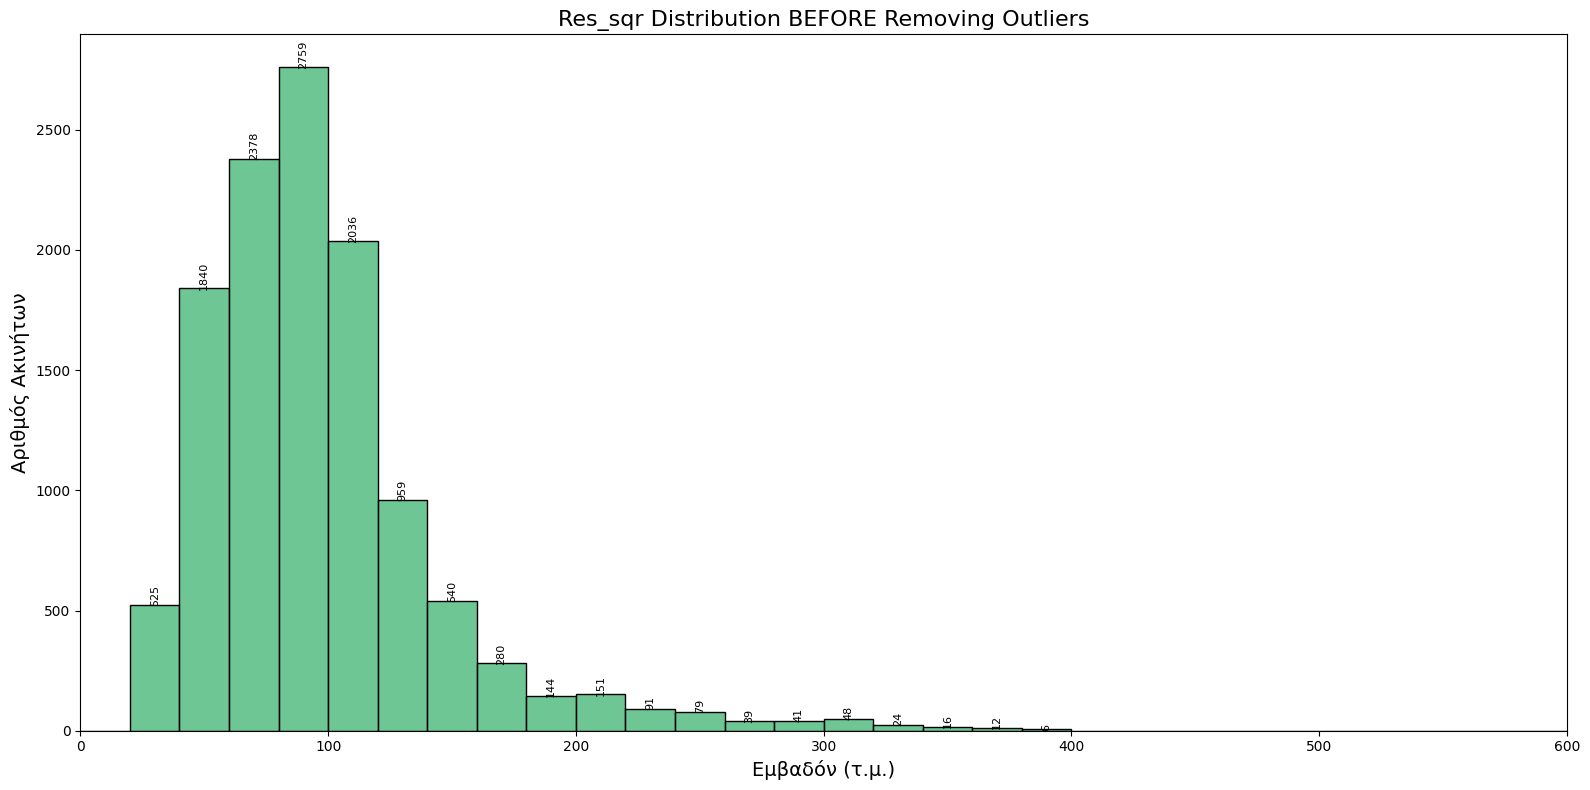

In [24]:
def plot_res_sqr_distribution_10(data, title):
    plt.figure(figsize=(16, 8))
    
    bins = np.arange(0, 600 + 10, 20)
    
    ax = sns.histplot(data['res_sqr'], bins=bins, kde=False, color='mediumseagreen')
    plt.title(title, fontsize=16)
    plt.xlabel('Εμβαδόν (τ.μ.)', fontsize=14)
    plt.ylabel('Αριθμός Ακινήτων', fontsize=14)
    
    plt.xlim(0, 600)
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    
    for p in ax.patches:
        if p.get_x() + p.get_width() <= 600:
            height = p.get_height()
            if height > 0:
                ax.text(p.get_x() + p.get_width()/2, height + 3, int(height), ha='center', fontsize=8, rotation=90)
    
    plt.tight_layout()
    plt.show()

plot_res_sqr_distribution_10(gdf, "Res_sqr Distribution BEFORE Removing Outliers")

In [9]:
gdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11968 entries, 0 to 11967
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   location_name      11968 non-null  object 
 1   location_name_eng  11968 non-null  object 
 2   location_region    11968 non-null  object 
 3   res_date           11968 non-null  object 
 4   res_type           11968 non-null  object 
 5   res_address        11968 non-null  object 
 6   res_price          11968 non-null  int64  
 7   res_price_sqr      11968 non-null  float64
 8   res_sqr            11968 non-null  float64
 9   levels             11968 non-null  object 
 10  bedrooms           11968 non-null  int64  
 11  bathrooms          11968 non-null  int64  
 12  status             11968 non-null  object 
 13  energyclass        11968 non-null  object 
 14  auto_heating       11968 non-null  int64  
 15  solar              11968 non-null  int64  
 16  cooling            119

# Machine Learning Methods for predicting res price

In [26]:
X = gdf[['house_age', 'bedrooms', 'bathrooms', 'solar', 'cooling', 'gas', 'lat', 'long', 'dist_to_metro']]
y = gdf['res_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define models
models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
}

# Evaluate models
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'R²': round(r2, 4)
    })

results_df = pd.DataFrame(results).sort_values(by='R²', ascending=False)
print("Performance Comparison:")
print(results_df)

Performance Comparison:
           Model       MAE      RMSE      R²
1        XGBoost  55702.43  80742.41  0.6726
0  Random Forest  56815.12  81742.69  0.6644


Based on the results, both models perform reasonably well in predicting residential prices. XGBoost slightly outperforms Random Forest with lower MAE and RMSE and a marginally higher R² (0.6726 vs 0.6644), indicating better accuracy and fit. The difference is small, so either model could be used, but XGBoost may capture complex patterns slightly better. Overall, the models explain around 67% of the variance in prices, leaving room for improvement with additional features or tuning.

# Future Work

- Incorporate additional geospatial features, such as distance to the sea, forests, parks, or other amenities, to better capture location value.  
- Expand the dataset and apply one-hot encoding for categorical features to include more property characteristics.  
- Perform hyperparameter tuning using grid search to optimize model performance.  
- Explore neural network architectures to capture complex, non-linear relationships in the data.
